In [12]:
!pip install grad-cam
!pip install opencv-python-headless==4.5.3.56
!pip install seaborn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1


In [100]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
from einops import rearrange
import os
os.chdir('/project/lcd_v2')
from run.tools.cli.infer import prepare_inference
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


plt.style.use('bmh')
plt.rcParams['svg.fonttype'] = 'none'

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [8]:
root_dir = 'work_dir/'
step_limit = 30

In [58]:
# helper function
def normalization(x, eps=1e-6):
        x = abs(x)
        # rescale gradients to between 0 and 1
        flatin = x.reshape((x.size(0),-1))
        temp, _ = flatin.min(1, keepdim=True)
        x = x - temp.unsqueeze(1)

        flatin = x.reshape((x.size(0),-1))
        temp, _ = flatin.max(1, keepdim=True)
        x = x / (temp.unsqueeze(1) + eps)
        return x

def get_input_gradient(model, objective, x):
    model.zero_grad()
    input_gradients = torch.autograd.grad(outputs=objective, inputs=x)[0]
    return input_gradients

def get_gradient_saliency(model, sample):
    x, y = copy.deepcopy(sample)
    x = {k: torch.tensor(v).unsqueeze(0).cuda() for k, v in x.items()}
    x['seq'].requires_grad_()
    model.eval()
    prob = model(x)
    objective = -1. * F.nll_loss(prob, y.cuda().flatten(), reduction='sum')
    input_gradient = get_input_gradient(model, objective, x['seq'])
    input_gradient = rearrange(input_gradient, 'b l c -> b c l')
    gradient = normalization(input_gradient).cpu()
    gradient = rearrange(gradient, 'b c l -> b l c')
    return {'seq':x['seq'], 'confidence': prob.softmax(dim=-1)[0, 1], 'gt': y, 'gradient': gradient.squeeze().reshape(-1, 2)}

class GradCAM1d(GradCAM):
    def get_cam_weights(self, input_tensor, target_layer, target_category, activations, grads):
        return np.mean(grads, axis=1)

    def scale_cam_image(self, cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = np.interp(np.linspace(0, target_size, target_size), np.linspace(0, target_size, len(img)), img)
            result.append(img)
        result = np.float32(result)

        return result

    def get_target_length(self, input_tensor):
        length = input_tensor.size(-2)
        return length

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      targets,
                      activations,
                      grads,
                      eigen_smooth=False):

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None] * np.transpose(activations, (0, 2, 1))
        cam = np.transpose(weighted_activations, (0, 2, 1)).sum(axis=-1)
        return cam

    def compute_cam_per_layer(
            self,
            input_tensor,
            targets,
            eigen_smooth):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_length(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            # cam = np.maximum(cam, 0)
            # print(np.max(cam), np.min(cam))
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

def get_cam_plots(target_idxs, mi, dl, axes=None, shift=False, default_shift='backward', save_dir=None):
    target_layers = [mi.model.backbone.layers[-1].norm2]
    cam = GradCAM1d(model=mi, target_layers=target_layers, use_cuda=True)
    if axes is None:
        fig, axes = plt.subplots(round(len(target_idxs)/3), 3, figsize=(24, round(len(target_idxs)/3)*4))

    cls = ['#DE1334', '#6752FF', '#0B2735']
    for i, ax in enumerate(axes.flatten()):
        if shift:
            if isinstance(dl.dataset[target_idxs[i]][0], np.ndarray):
                input_tensor = torch.tensor(dl.dataset[i][0]).unsqueeze(0).cuda()
            else:
                input_tensor = dl.dataset[target_idxs[i]][0].clone().unsqueeze(0).cuda()
            if default_shift == 'forward':
                input_tensor[:, :, 1] = torch.cat((input_tensor[0, 0, 1].reshape(1, 1, 1).tile(1, step_limit//5, 1), input_tensor[:, :-step_limit//5, 1].unsqueeze(-1)), dim=1).squeeze()
            elif default_shift == 'backward':
                input_tensor[:, :, 1] = torch.cat((input_tensor[:, step_limit//5:, 1].unsqueeze(-1), input_tensor[0, -1, 1].reshape(1, 1, 1).tile(1, step_limit//5, 1)), dim=1).squeeze()
            else:
                raise ValueError('default_shift must be either forward or backward')
        else:
            input_tensor =  torch.tensor(dl.dataset[target_idxs[i]][0]).unsqueeze(0).cuda()
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])
        ax.plot(dl.dataset[target_idxs[i]][0][:, 0], c=cls[0], linestyle='-', label='cause')
        ax.plot(dl.dataset[target_idxs[i]][0][:, 1], c=cls[1], linestyle='--', label='result')
        ax.plot(grayscale_cam.squeeze(), c=cls[2], label='grad_cam')
        confidence = mi(input_tensor).softmax(dim=-1)[:, 1].detach().cpu().numpy()[0]
        label = int(dl.dataset[target_idxs[i]][1])
        if shift:
            ax.set_title(f'Current Label: {int(label==0)} | Prediction: {int(confidence>0.7)} | Confidence: {confidence:.2f}', fontdict={'family': 'Serif'})
        else:
            ax.set_title(f'Label: {label} | Prediction: {int(confidence>0.7)} | Confidence: {confidence:.2f}', fontdict={'family': 'Serif'})
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc='lower left', prop={'family': 'Serif'}, labelcolor='black')

    if save_dir is not None and not save_dir.endswith('.pdf'):
        plt.savefig(f"{save_dir}.svg")
    elif save_dir is not None:
        plt.savefig(save_dir)


### Gradient Saliency

In [59]:
# get result from deep learning method
cfgs = [
        'mos6502_big_transformer_nhead_3_depth_8_dim_192_bs_1024_lr_1e-3/mos6502_big_transformer_nhead_3_depth_8_dim_192_bs_1024_lr_1e-3.py',
        ]
ckpts = [
         'mos6502_big_transformer_nhead_3_depth_8_dim_192_bs_1024_lr_1e-3/ckpts/exp_name=mos6502_big_transformer_nhead_3_depth_8_dim_192_bs_1024_lr_1e-3-cfg=mos6502_big_transformer_nhead_3_depth_8_dim_192_bs_1024_lr_1e-3-bs=1024-seed=42-val_average_precision=0.5576.ckpt',
         ]
cfgs, ckpts = [root_dir + cfg for cfg in cfgs], [root_dir + ckpt for ckpt in ckpts]

di, mi = prepare_inference(cfgs[0], ckpts[0])
mi = mi.cuda()

di.setup('test')
dl = di.test_dataloader()

# get result from noise injection


di_noise, mi_noise = prepare_inference(cfgs[0], ckpts[0])
scale = 0.05
noised_npy = f".cache/sim_data/DonkeyKong/HR/window_640_768/Regular_3510_step_128_rec_30_window_640_768_Noise_{scale}.npy"
di_noise.data_cfg.test.data_root = noised_npy
di_noise.data_cfg.test.split = f".cache/sim_data/DonkeyKong/HR/window_640_768/csv/fold_seed_42/test_ds_1.0_unique_True.csv"
di_noise.data_cfg.num_workers = 0

di_noise.setup('test')
di_noise.testset.windows = {noised_npy: np.load(noised_npy, mmap_mode='r')}
di_noise.testset.time_series_df["file_path"] = noised_npy
mi_noise = mi_noise.cuda()
dl_noise = di_noise.test_dataloader()

/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kw

less than 400 transistors:  [  256  3968 15488 23808 23936 24064 24192 24320 24448 24576 24704 24832
 24960 25088 25216 25344 25472 33280 33664 34176 34560 34944 35072 35584
 35840 35968 40064 40576]
pos pairs more than 400:  [  512   896  1280  1664  2048  2432  2816  3200  3584  4224  4608  4992
  5376  5760  6144  6528  6912  7296  7680  8064  8448  8832  9216  9600
  9984 10368 10752 11136 11520 11904 12288 12672 13056 13440 13824 14208
 14592 14976 15360 15744 16128 16512 16896 17280 17664 18048 18432 18816
 19200 19584 19968 20352 20736 21120 21504 21888 22272 22656 23040 23424
 23808 25728 26112 26496 26880 27264 27648 28032 28416 28800 29184 29568
 29952 30336 30720 31104 31488 31872 32256 32640 33024 33408 33792 35328
 35712 36096 36480 36864 37248 37632 38016 38400 38784 39168 39552 39936
 40320 40704]


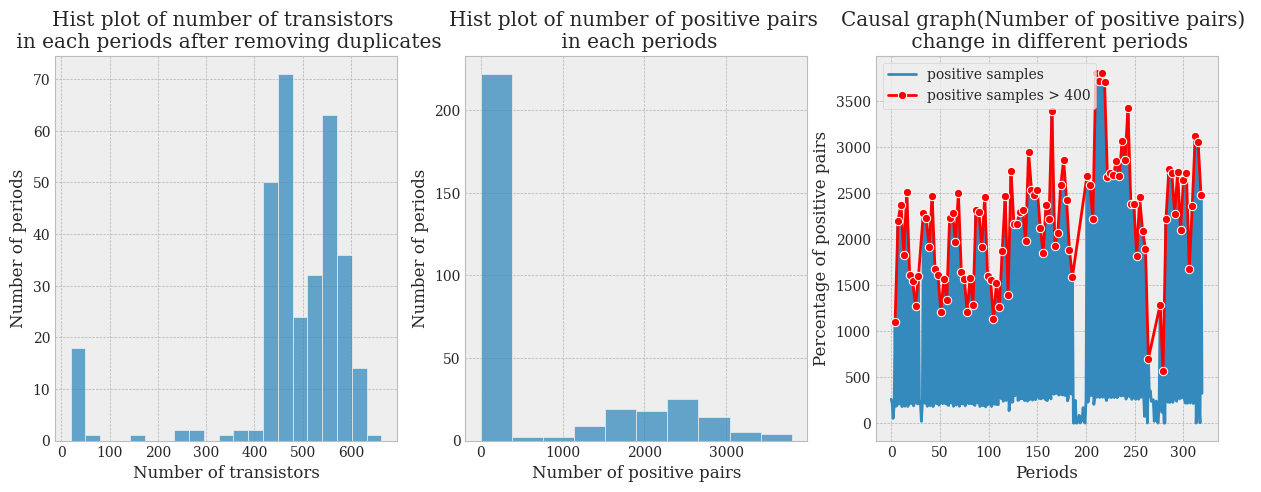

In [60]:
import pickle
from seaborn import histplot, lineplot

plt.rcParams['font.family'] = 'Serif'

unique_ts = []
n_pos_pairs = []
p_pos_pairs = []
for i in range(0, 40960, 128):
    adj_test = pickle.load(open(f'.cache/sim_data/DonkeyKong/HR/window_{i}_{i+128}/adjacency_matrix.pkl', 'rb'), encoding='latin1')
    unique_ts.append(len(adj_test))
    n_pos_pairs.append(len(sum([v for k, v in adj_test.items()], [])))
    p_pos_pairs.append(n_pos_pairs[-1] / len(adj_test) / len(adj_test))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
histplot(unique_ts)
plt.title("Hist plot of number of transistors \n in each periods after removing duplicates")
plt.xlabel("Number of transistors")
plt.ylabel("Number of periods")

plt.subplot(1, 3, 2)
histplot(n_pos_pairs)
plt.title("Hist plot of number of positive pairs \n in each periods")
plt.xlabel("Number of positive pairs")
plt.ylabel("Number of periods")

plt.subplot(1, 3, 3)
plt.title("Causal graph(Number of positive pairs) \n change in different periods")
plt.ylabel("Percentage of positive pairs")
plt.xlabel("Periods")
lineplot(n_pos_pairs, label='positive samples')
lineplot(x=np.where(np.array(n_pos_pairs)>400)[0], y=np.array(n_pos_pairs)[np.where(np.array(n_pos_pairs)>400)[0]], marker='o', color='red', label='positive samples > 400')
print("less than 400 transistors: ", np.where(np.array(unique_ts)<400)[0]*128)
print("pos pairs more than 400: ", np.where(np.array(n_pos_pairs)>400)[0]*128)

plt.savefig('/project/lcd_v2/figure/Figure 5. CAM/mos_stat.pdf')

In [ ]:
# test
from pytorch_lightning import Trainer

res = {}

for test_split in ((0, 128), (128, 256), (384, 512), (512, 640), (640, 768)):
    print(f"test split: {test_split}")
    di.data_cfg.test.data_root=f".cache/sim_data/DonkeyKong/HR/window_{test_split[0]}_{test_split[1]}/Regular_3510_step_128_rec_30_window_{test_split[0]}_{test_split[1]}.npy"
    di.data_cfg.test.split=f".cache/sim_data/DonkeyKong/HR/window_{test_split[0]}_{test_split[1]}/csv/fold_seed_42/test_ds_1.0_unique_True.csv"
    di.data_cfg.num_workers = 0
    di.data_cfg.test_batch_size=512
    di.setup('test')
    trainer = Trainer(gpus=1)
    if test_split not in res:
        res[test_split] = {}
    res[test_split]['regular'] = trainer.test(mi, dataloaders=di.test_dataloader())[0]
    for noise_scale in [0.03, 0.05, 0.1]:
        print(f"noise scale: {noise_scale}")
        noised_npy = f".cache/sim_data/DonkeyKong/HR/window_{test_split[0]}_{test_split[1]}/Regular_3510_step_128_rec_30_window_{test_split[0]}_{test_split[1]}_Noise_{noise_scale}.npy"
        di.data_cfg.test.data_root = noised_npy
        di.data_cfg.test.split = f".cache/sim_data/DonkeyKong/HR/window_{test_split[0]}_{test_split[1]}/csv/fold_seed_42/test_ds_1.0_unique_True.csv"
        di.data_cfg.num_workers = 0

        di.setup('test')
        di.testset.windows = {noised_npy: np.load(noised_npy, mmap_mode='r')}
        di.testset.time_series_df["file_path"] = noised_npy
        trainer = Trainer(gpus=1)
        res[test_split][f'noise_{noise_scale}'] = trainer.test(mi, dataloaders=di.test_dataloader())[0]


In [8]:
res

{(0,
  128): {'regular': {'test_FocalLoss_epoch': 0.00960511714220047,
   'test_loss_epoch': 0.00960511714220047,
   'test_average_precision': 0.5516467690467834,
   'test_auroc': 0.9822372198104858}, 'noise_0.03': {'test_FocalLoss_epoch': 0.0095811253413558,
   'test_loss_epoch': 0.0095811253413558,
   'test_average_precision': 0.551032304763794,
   'test_auroc': 0.9828976392745972}, 'noise_0.05': {'test_FocalLoss_epoch': 0.009632537141442299,
   'test_loss_epoch': 0.009632537141442299,
   'test_average_precision': 0.5225436687469482,
   'test_auroc': 0.981298565864563}, 'noise_0.1': {'test_FocalLoss_epoch': 0.009525691159069538,
   'test_loss_epoch': 0.009525691159069538,
   'test_average_precision': 0.47087275981903076,
   'test_auroc': 0.9775341749191284}},
 (128,
  256): {'regular': {'test_FocalLoss_epoch': 0.013325508683919907,
   'test_loss_epoch': 0.013325508683919907,
   'test_average_precision': 0.4913769066333771,
   'test_auroc': 0.9977307319641113}, 'noise_0.03': {'test_Fo

In [ ]:
# test
from pytorch_lightning import Trainer

res = {}

for game in ["DonkeyKong", "Pitfall", "SpaceInvaders"]:
    print("Game:", game)
    for test_split in ((0, 128), (128, 256), (384, 512), (512, 640), (640, 768)):
        print(f"test split: {test_split}")
        di.data_cfg.test.data_root=f".cache/sim_data/{game}/HR/window_{test_split[0]}_{test_split[1]}/Regular_3510_step_128_rec_30_window_{test_split[0]}_{test_split[1]}.npy"
        di.data_cfg.test.split=f".cache/sim_data/{game}/HR/window_{test_split[0]}_{test_split[1]}/csv/fold_seed_42/test_ds_1.0_unique_True.csv"
        di.data_cfg.num_workers = 0
        di.data_cfg.test_batch_size=512
        di.setup('test')
        trainer = Trainer(gpus=1)
        if test_split not in res:
            res[test_split] = {}
        res[test_split]['regular'] = trainer.test(mi, dataloaders=di.test_dataloader())[0]


In [87]:
from tqdm.notebook import tqdm

pred = []
label = []
di, mi = prepare_inference(cfgs[0], ckpts[0])
mi = mi.cuda()
di.data_cfg.num_workers = 0
# di.data_cfg.test.data_root=f".cache/sim_data/DonkeyKong/HR/window_0_128/Regular_3510_step_128_rec_30_window_0_128.npy"
# di.data_cfg.test.split=f".cache/sim_data/DonkeyKong/HR/window_0_128/csv/fold_seed_42/test_ds_1.0_unique_True.csv"
di.setup('test')
dl = di.test_dataloader()
with torch.no_grad():
    mi.eval()
    mi = mi.cuda()
    for x, y in tqdm(dl):
        _pred = mi(x.cuda()).softmax(dim=-1)[:, -1].detach().cpu().numpy()
        pred.append(_pred)
        label.append(y.cpu().numpy())
pred = np.concatenate(pred)
label = np.concatenate(label)

# auprc
from sklearn.metrics import average_precision_score
average_precision_score(label, pred)



/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/11 [00:00<?, ?it/s]

0.5991124128937406

In [89]:
cls_threshold = 0.7

binary_pred = np.where(pred>cls_threshold, 1, 0)
# find the index where pred, label all equal to 1
np.where((binary_pred==label) & (binary_pred==1)), len(np.where((binary_pred==label) & (binary_pred==1))[0])/sum(binary_pred)

((array([  743,  1480,  3413,  6227,  7115,  7560,  8596,  9489, 11114,
         12295, 13477, 13629, 14217, 14812, 15414, 16138, 17622, 19839]),),
 0.23376623376623376)

<Axes: ylabel='Count'>

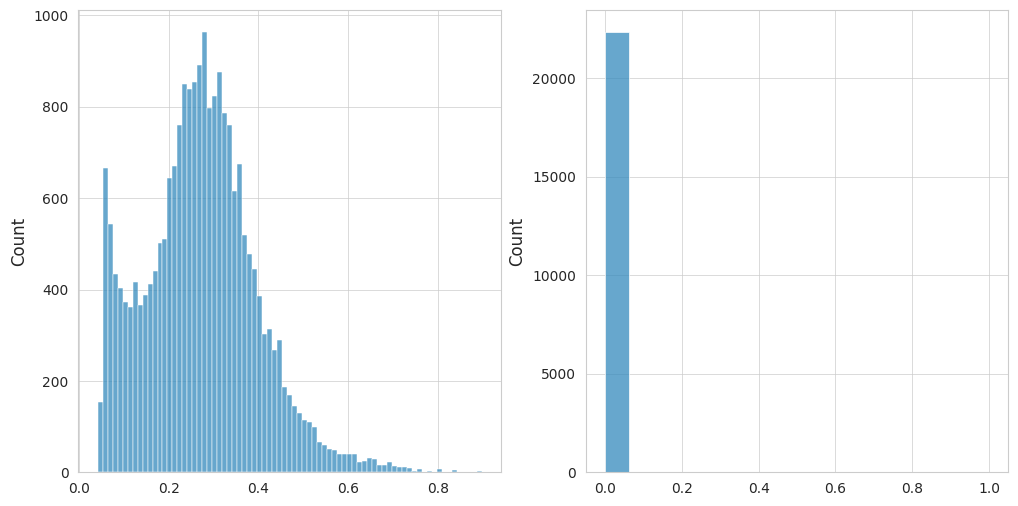

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(pred, ax=axes[0])
sns.histplot(label, ax=axes[1])


### GradCAM

/tmp/ipykernel_57/3507621153.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor =  torch.tensor(dl.dataset[target_idxs[i]][0]).unsqueeze(0).cuda()


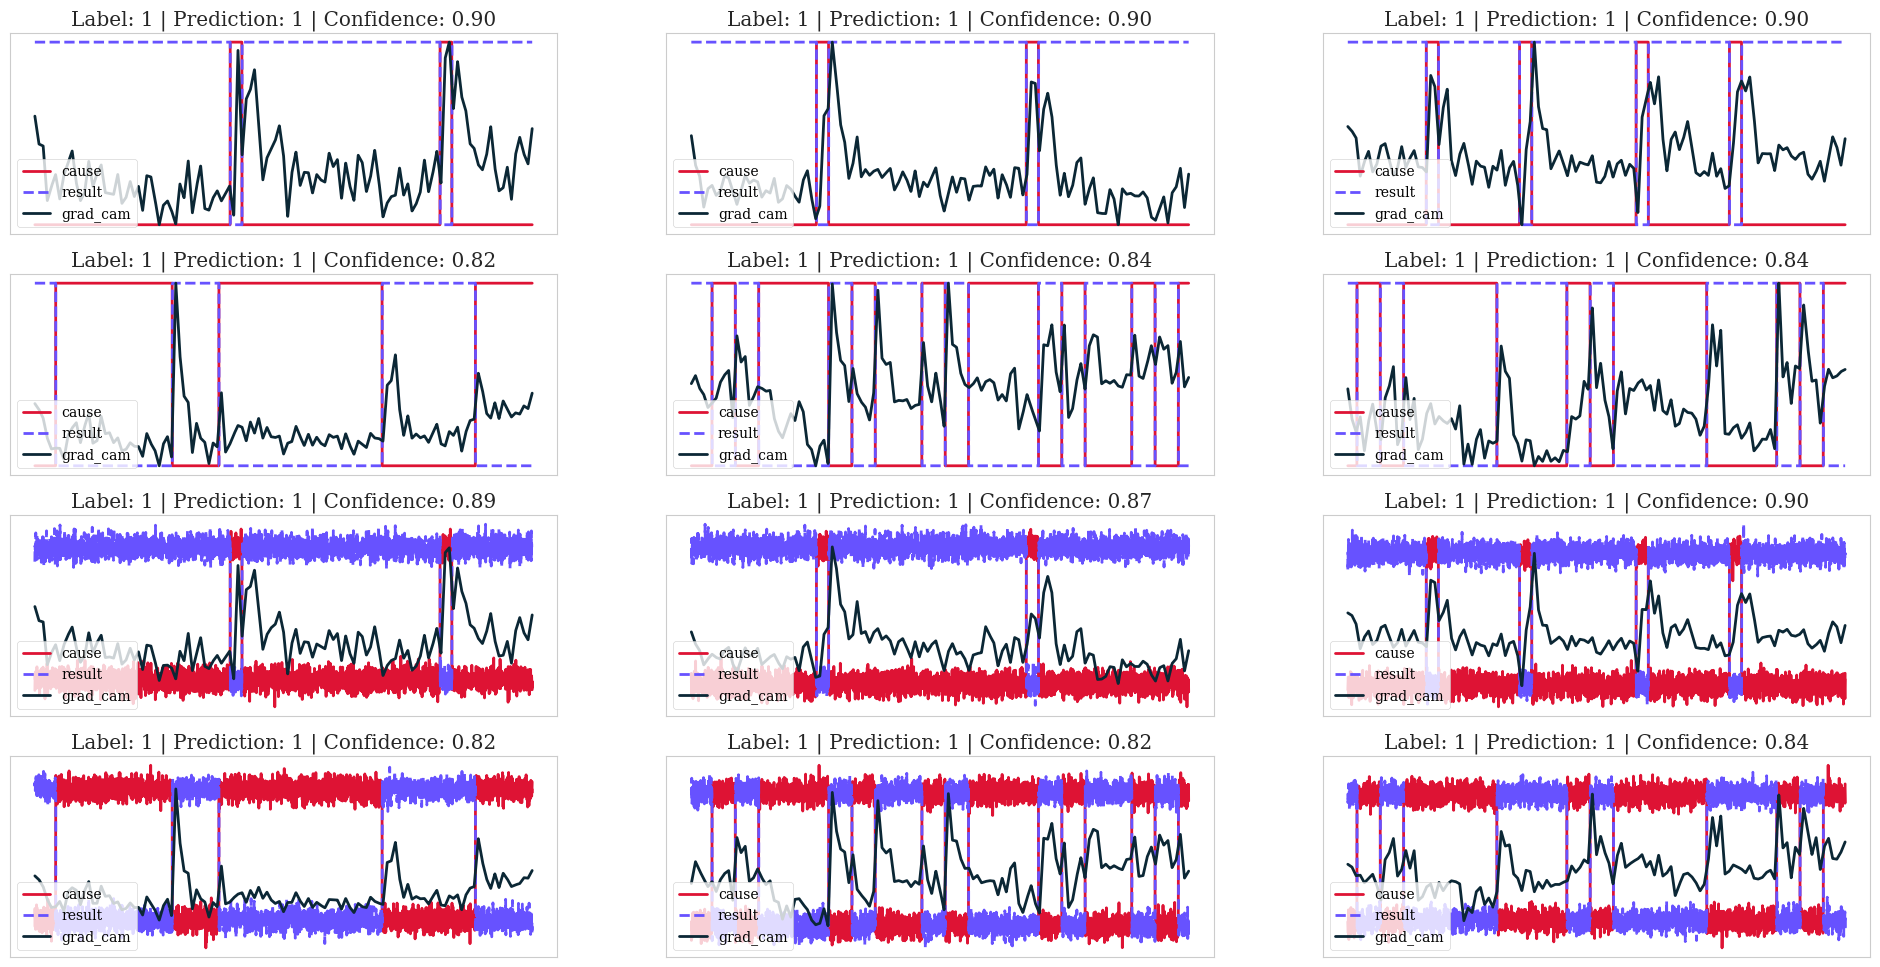

In [91]:
fig, axes = plt.subplots(4, 3, figsize=(24, 12))
target_idxs = [743,  1480,  3413,  7115,  7560,  9489] # [3047, 67020, 70069, 82250, 97485, 141397] # [120518, 151394, 187052]
get_cam_plots(target_idxs, mi, dl, axes.flatten()[:6])
get_cam_plots(target_idxs, mi_noise, dl_noise, axes.flatten()[6:12])
fig.savefig('/project/lcd_v2/figure/Figure 5. CAM/cam.svg')

/tmp/ipykernel_57/3507621153.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor =  torch.tensor(dl.dataset[target_idxs[i]][0]).unsqueeze(0).cuda()


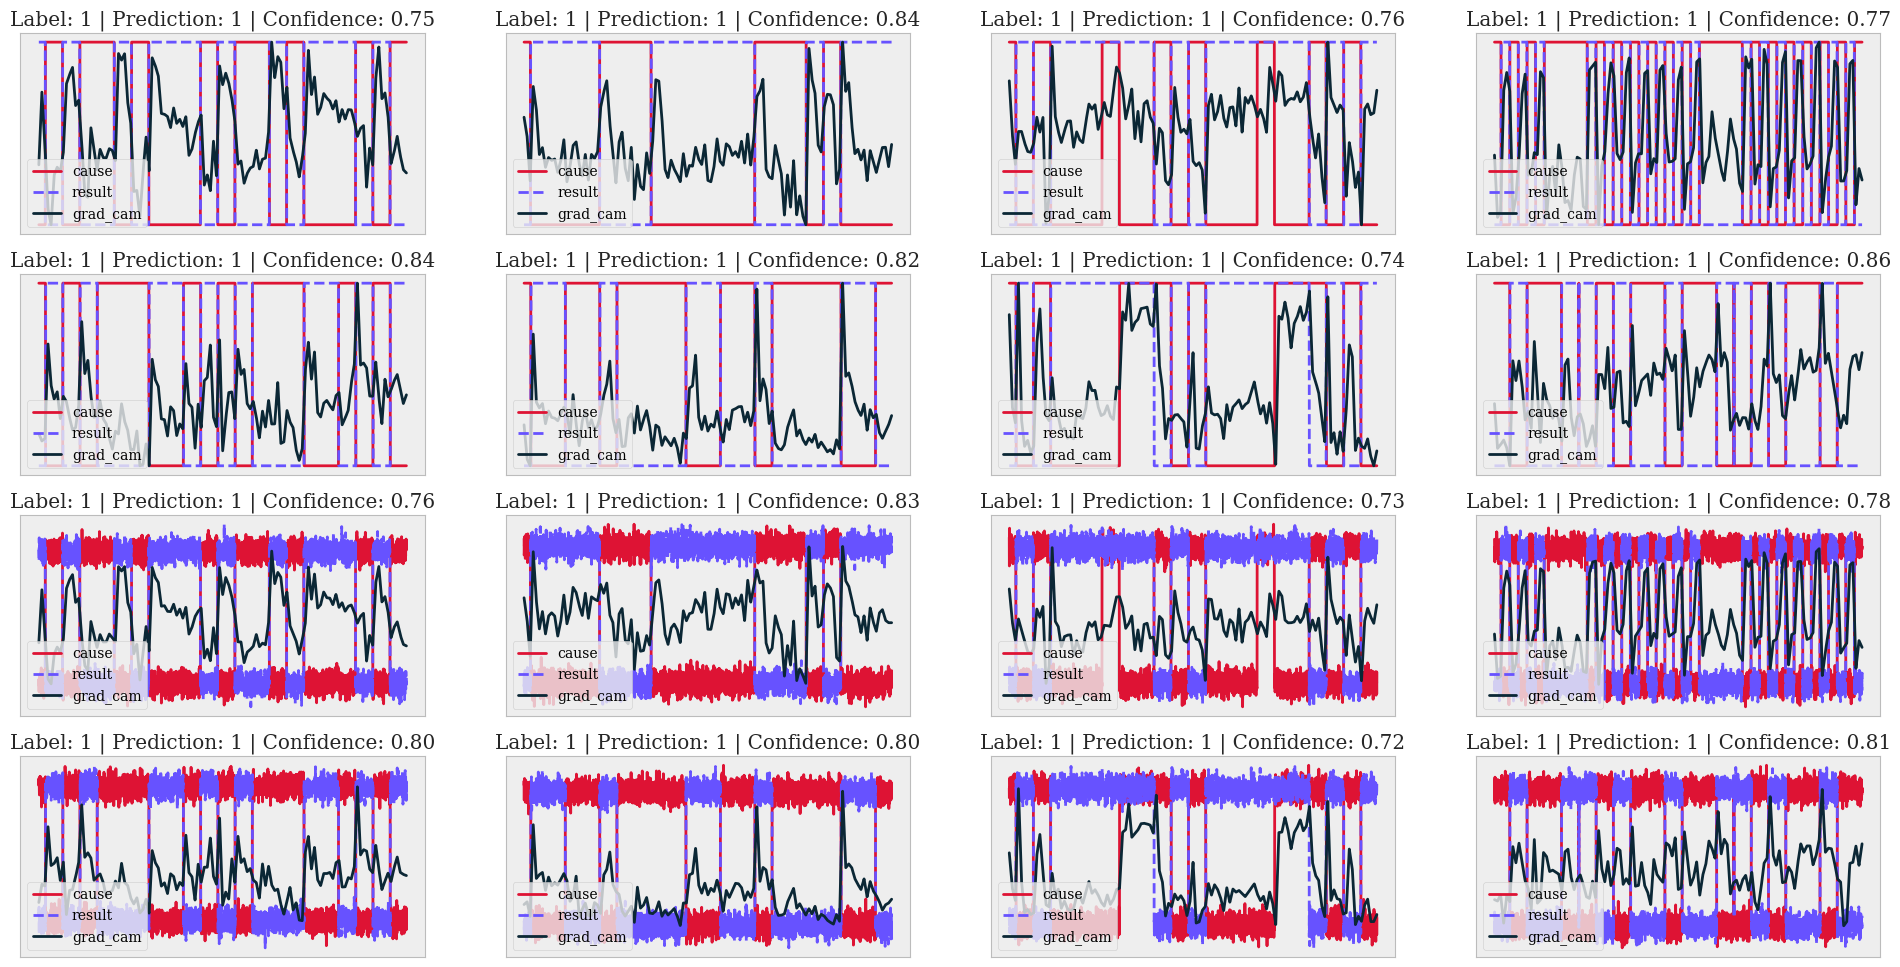

In [101]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
target_idxs = [11114, 12295, 13477, 13629, 14217, 14812, 15414, 16138] # [120518, 151394, 187052]
get_cam_plots(target_idxs, mi, dl, axes.flatten()[:8])
get_cam_plots(target_idxs, mi_noise, dl_noise, axes.flatten()[8:16])
fig.savefig('/project/lcd_v2/figure/Figure 6. Supplemental/cam_supplemental.pdf')

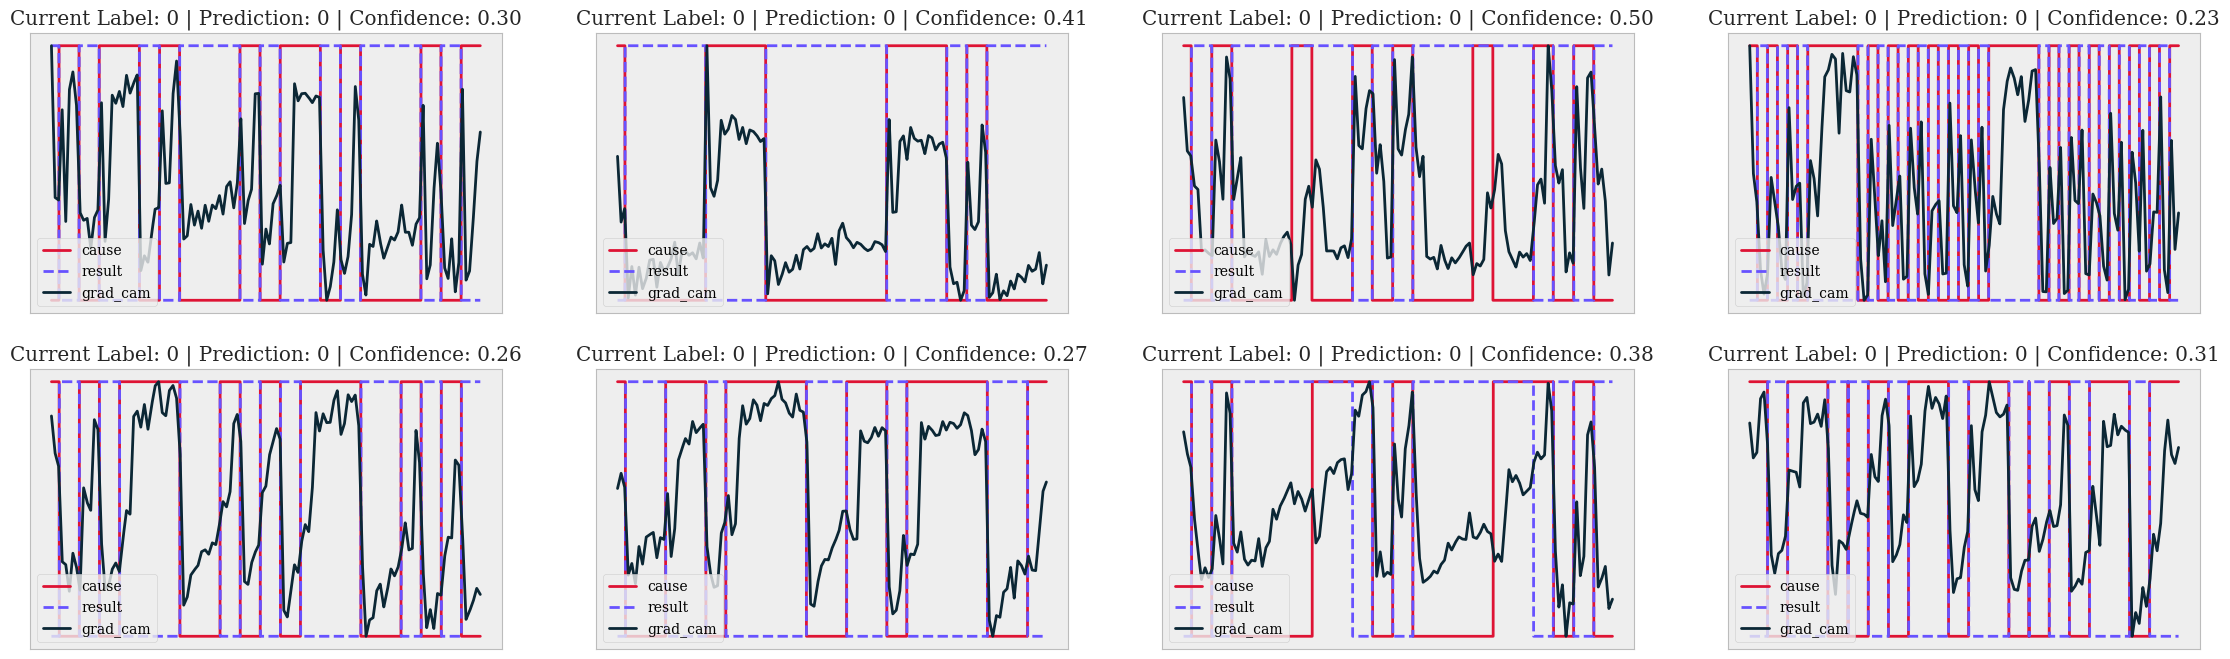

In [102]:
fig, axes = plt.subplots(2, 4, figsize=(28, 8))

get_cam_plots(target_idxs, mi, dl, axes=axes, shift=True, default_shift='backward', save_dir='/project/lcd_v2/figure/Figure 6. Supplemental/reverse_supplemental.pdf')

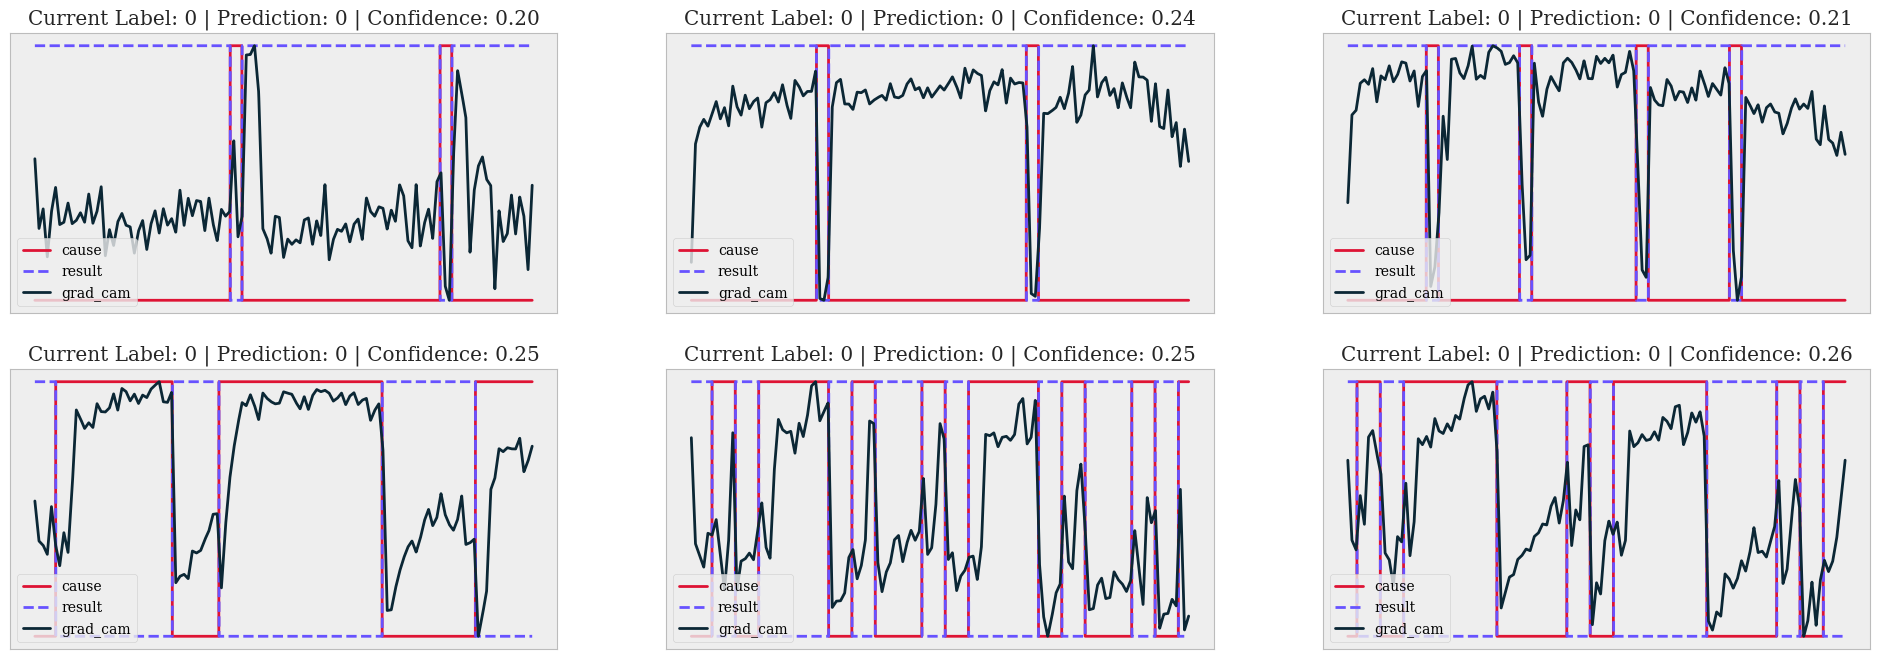

In [77]:
get_cam_plots(target_idxs, mi, dl, shift=True, default_shift='backward', save_dir='/project/lcd_v2/figure/Figure 5. CAM/reverse')

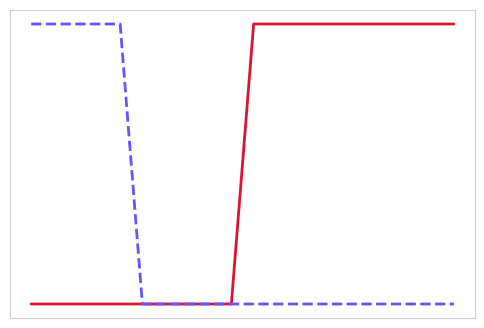

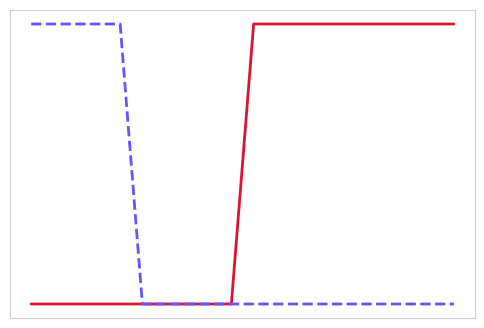

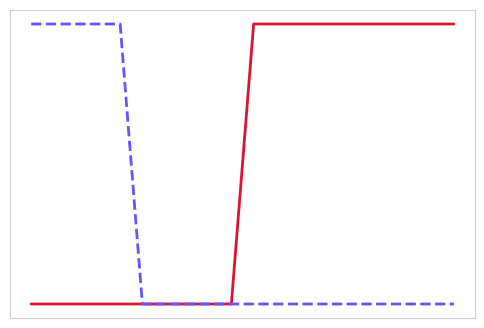

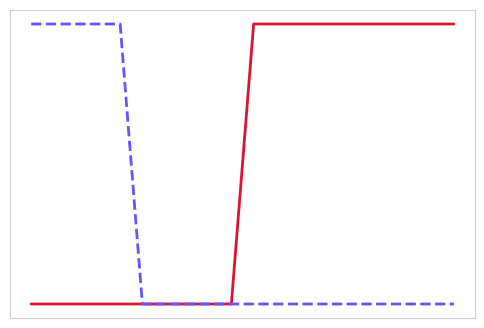

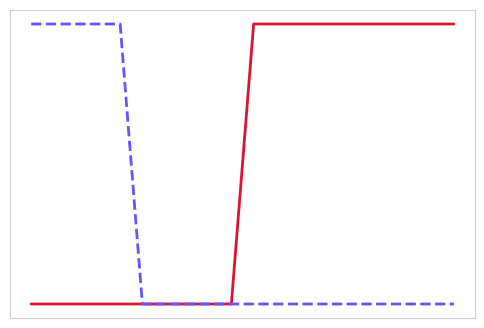

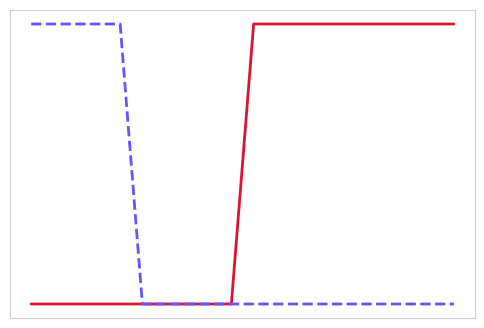

In [74]:
# plot a zoom version of the backwarded
cls = ['#DE1334', '#6752FF', '#0B2735']
for i, idx in enumerate(target_idxs):
    plt.figure(figsize=(6, 4))
    input_tensor = dl.dataset[idx][0]
    input_tensor[:, 1] = torch.cat((input_tensor[step_limit//5:, 1].unsqueeze(-1), input_tensor[-1, 1].reshape(1, 1).tile(step_limit//5, 1)), dim=0).squeeze()
    input_tensor = input_tensor.numpy()
    # find the start point
    start_idx = np.where(input_tensor[:, 0] != input_tensor[0, 0])[0][0]
    plt.plot(input_tensor[start_idx-10:start_idx+10, 0], c=cls[0], linestyle='-', label='cause')
    plt.plot(input_tensor[start_idx-10:start_idx+10, 1], c=cls[1], linestyle='--', label='result')
    # remove the xticks
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'/project/lcd_v2/figure/Figure 5. CAM/reverse_zoom{idx}.svg')

In [127]:
import pickle

marked_data = np.load('/project/lcd_v2/.cache/sim_data/DonkeyKong/HR/Regular_3510_step_81920.npy', mmap_mode='r')

In [133]:
marked_data = np.where(marked_data == 255, -1, marked_data)
marked_data = marked_data[:, :np.where(marked_data[0] != -1)[0][-1] + 2]
# before padding
print('raw sample length: ', marked_data.shape[1])
snippet_lengths = []
markers = np.where(marked_data[0] == -1)[0].tolist()

raw sample length:  618912
